<a href="https://colab.research.google.com/github/AndoneSabin99/Unsupervised-Domain-Adaptation-unitn/blob/main/232098_229701.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Deep Learning Project 2022 - Unsupervised Domain Adaptation
## Sabin Andone - Jacopo Clocchiatti



##Introduction and related work
For the purpose of this project it was requested to realize a deep learning framework that could be trained and evaluated on a UDA (Unsupervised Domain Adaptation) setting. UDA is basically transfering the knowledge of a label-rich source domain to an unlabelled target domain. However, there are two issues to consider in this case:

1.   domain shift: the two domains are distributed on different manifolds and for this reason there is a domain gap across domains
2.   it is not allowed to have labels on target domain: in order to train supervisedly on the source domain and, at the same time, unsupervisedly on the target domain it is necessary to implement methods that does not require having labels on the target domain.

Considering these two points, it has been choosen to implement an adversarial loss method into the deep learning framework, which traines the model by backpropagation. This project is divided in two main parts: the source-only and the UDA part. In the source-only part the data is loaded and then a model is defined. After that the model is trained supervisedly only on the source domain, while the testing part is performed on the target domain. In the second part, a loss function (adversarial loss function in this case) is implemented into the framework and then training and testing is performed again. But now, the training is performed both supervisedly on the source domain and unsupervisedly on the target domain. At the end of each part an accuracy score is achieved. The gain is the difference between these scores and indicates how much better the accuracy is with the adversarial loss function.

####Notes for running the notebook
In order to run this notebook, execute every code chunk in the order as they are shown in this notebook. After finishing to train both with and without UDA approach, it is possible to repeat the experiment for the opposite direction. In this case, just set the target domain to the other dataset and from that point repeat the execution.

##The Adaptiope Dataset
Adaptiope [1] dataset contains images belonging to 3 different domains, each containing 123 categories. Since this dataset contains a lot of images, for the purpose of this project it is necessary to only get 2 domains from the dataset: the **product images** and **the real life**. For both of these domains, we only consider 20 categories from the 123 categories in the original dataset. These categories are: backpack, bookcase, car jack, comb, crown, file cabinet, flat iron, game controller,
glasses, helicopter, ice skates, letter tray, monitor, mug, network switch, over-ear headphones, pen, purse, stand mixer and stroller.


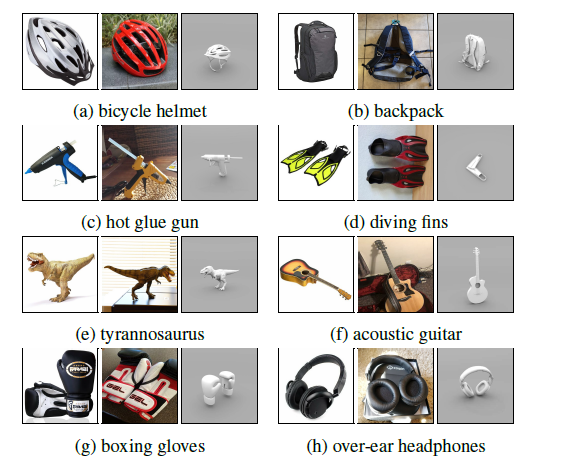

##Data Setup
First, in order to be able to train and to evaluate the UDA framework proposed for this project, it is necessary to load the data from the Adaptiope object recognition dataset, which is publicly available for [download](https://drive.google.com/file/d/1FmdsvetC0oVyrFJ9ER7fcN-cXPOWx2gq/view). To do this, it is necessary to store the data on the 'datasets' folder and the mount the Google Drive folder on Colab. Since it is also hosted on Google Drive, it is possible to access the dataset without downloading it by just adding a Google Drive shortcut on the folder.

First we import the necessary libraries for this part.

In [ ]:
import os
from os import listdir
from os.path import join, isfile
from tqdm import tqdm
from google.colab import drive
from shutil import copytree

Now, we mount the google drive file in order to get the Adaptiope.zip file and put it in our dataset directory

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir dataset
!cp "gdrive/My Drive/datasets/Adaptiope.zip" dataset/
!ls dataset

Adaptiope.zip


In [ ]:
!unzip dataset/Adaptiope.zip

As said before in the Dataset section, we only get 2 domains and 20 categories for each domain. So it is necessary to create a new directory called adaptiope_small and put all the necessary data there from the original dataset.

In [ ]:
!rm -rf adaptiope_small

In [ ]:
!mkdir adaptiope_small
classes = listdir("Adaptiope/product_images")
classes = ["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet", "flat iron", "game controller", "glasses",
           "helicopter", "ice skates", "letter tray", "monitor", "mug", "network switch", "over-ear headphones", "pen",
           "purse", "stand mixer", "stroller"]
for d, td in zip(["Adaptiope/product_images", "Adaptiope/real_life"], ["adaptiope_small/product_images", "adaptiope_small/real_life"]):
  os.makedirs(td, exist_ok=True)
  for c in tqdm(classes):
    c_path = join(d, c)
    c_target = join(td, c)
    copytree(c_path, c_target)

100%|██████████| 20/20 [00:05<00:00,  3.90it/s]


#Preparations

Once the dataset is corretly setup on Colab, it is possible to start with the actual coding part. First, it is necessary to import the following libraries:

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F

##GPU
Models and datasets usually have huge sizes, so GPUs are efficient at performing matrix operations in a reasonable amount of time. In this case, we get the default device available and check if cuda device is available.

In [ ]:
def get_default_device():

    #pick GPU if available, else pick CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()

## Data loading
**Get_data(...)** is a method that aims to compactly return the dataloaders that we need, introducing some transformations. In our specific case, we have to specify the batch size, the source domain, the target domain roots and the number of workers.

In [ ]:
'''
Input arguments:
  batch_size: mini batch size used during training
  img_root_source: path to the dataset parent folder for the source domain.
  img_root_target: path to the dataset parent folder for the target domain.
  num_workers: number of workers for DataLoader
'''

def get_data(batch_size, img_root_source, img_root_target, num_workers):

  # prepare data transformations for the train loader
  transform = list()
  transform.append(T.Resize((256, 256)))                      # resize each image to 256 x 256
  transform.append(T.RandomCrop((224, 224)))                  # randomly crop a 224 x 224 patch, for data augmentation
  transform.append(T.ToTensor())                              # convert Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225]))    # normalize with ImageNet mean
  transform = T.Compose(transform)                            # compose the above transformations into one

  # load source domain data
  dataset_source = torchvision.datasets.ImageFolder(root=img_root_source, transform=transform)

  # load target domain data
  dataset_target = torchvision.datasets.ImageFolder(root=img_root_target, transform=transform)

  # create train and test splits (80/20) for source domain
  num_samples_source = len(dataset_source)
  source_training_samples = int(num_samples_source * 0.8)
  source_test_samples = num_samples_source - source_training_samples

  source_training_data, source_test_data = torch.utils.data.random_split(dataset_source,
                                                           [source_training_samples, source_test_samples])

  #repeat splitting for target domain
  num_samples_target = len(dataset_target)
  target_training_samples = int(num_samples_target * 0.8)
  target_test_samples = num_samples_target - target_training_samples

  target_training_data, target_test_data = torch.utils.data.random_split(dataset_target,
                                                           [target_training_samples, target_test_samples])

  # initialize dataloaders
  #PS: source_test_loader is not necessary at all since we are training on source_train and target_train and testing only on target_test
  source_train_loader = torch.utils.data.DataLoader(source_training_data, batch_size, shuffle=True, num_workers=num_workers)
  #source_test_loader = torch.utils.data.DataLoader(source_test_data, batch_size, shuffle=False, num_workers=num_workers)
  target_train_loader = torch.utils.data.DataLoader(target_training_data, batch_size, shuffle=True, num_workers=num_workers)
  target_test_loader = torch.utils.data.DataLoader(target_test_data, batch_size, shuffle=False, num_workers=num_workers)

  return source_train_loader, target_train_loader,target_test_loader

Set the batch size, number of workers and the two domains, so we can execute the get_data(...) function. Moreover, we have to choose our target domain

In [ ]:
batch_size = 64
domain_pi, domain_rl = '/content/adaptiope_small/product_images', '/content/adaptiope_small/real_life'
num_workers = 2  #3  or more workers would be better for a speedy training, but because google colab often suggests to work with less workers, use 2

#we choose which dataset will be the target domain
target = 'real_life'
#target = 'product_images'

Load the data using the function above

In [ ]:
if (target == 'real_life'):
    source_train_loader, target_train_loader, target_test_loader = get_data(batch_size, domain_pi, domain_rl, num_workers)
else:
    source_train_loader, target_train_loader, target_test_loader = get_data(batch_size, domain_rl, domain_pi, num_workers)

## Backbone Definition
For the purpose of this project, we are using a ResNet backbone, since it is one of the most effective backbones for image classification and it is able to maintain a low error rate much deeper in the network. In this case, Resnet 50 variant is choosen for this work.
ResNetBackbone is the class which defines a ResNet50 with pretrained weights and adapted to work for both source only part and UDA part of the experiment.

In [ ]:
from torchvision import models

resnet_dict = {
    "resnet18": models.resnet18,
    "resnet34": models.resnet34,
    "resnet50": models.resnet50,
    "resnet101": models.resnet101,
    "resnet152": models.resnet152,
}

def get_backbone(name):
        return ResNetBackbone(name)

class ResNetBackbone(nn.Module):
    """
	  ResNet model inspired from official Pytorch repository:
    https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
	  """

    def __init__(self, network_type):

        super(ResNetBackbone, self).__init__()

        #get the resnet-50 with pretrained weights
        resnet = resnet_dict[network_type](pretrained=True)

        #set resnetbackbone's layers as the model's layers
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool

        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        self.avgpool = resnet.avgpool
        self._feature_dim = resnet.fc.in_features

        del resnet

    #forward pass function called during the train and test
    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

    def output_num(self):
        return self._feature_dim

##Network Definition

The network for source only part is composed in two main parts: the ResNet backbone and the linear layer which is added after the backbone definition. The ResNet backbone acts as a feature extractor while the linear layer is the label predictor. These two elements together form a standard feed-forward architecture for image classification.

More formally, a deep feed-forward architecture is defined and this architecture predicts the labels y given input x. This mapping is decomposed in two main parts. First, the input x is mapped by a mapping Gf (feature extractor) to a D-dimensional feature vector f ∈ ℜ^D. We denote such feature vector as f = Gf(x;θf), where θf are the parameters of layers in feature extractor mapping. Then, the feature vector f is mapped by Gy mapping (label predictor) to the label y. θy are the parameters denoted on this mapping.
[2]

In [ ]:
class TransferNet(nn.Module):
    def __init__(self, num_class):
        super(TransferNet, self).__init__()

        #get the backbone
        self.model = get_backbone('resnet50')

        #get number of features
        feature_dim = self.model._feature_dim

        #add linear classifier layer
        classifier_layer = torch.nn.Linear(feature_dim, num_class)
        self.model.classifier_layer = classifier_layer


    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        return self.forward(x)

Defining the model. In this case, we have to pass the the number of classes (always 20 in our case) as parameter

In [ ]:
model = TransferNet(20).to(device)  #20 is the number of classes
print(model)

TransferNet(
  (model): ResNetBackbone(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


##Train and test

We define our training and test functions for the source only part of the UDA experiment. In this case we have to choose one of the two domains as the source domain and the other one as the target domain. After doing such decision, we train **supervisedly** on the source domain. The test must be done on the target domain. The training algorithm used in this case is backpropagation.

In [ ]:
def training_step_so(model, data_loader, optimizer, cost_function, device='cuda'):

  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  # set the network to training mode
  model.train()

  # iterate over the training set
  for batch_idx, (inputs, targets) in enumerate(data_loader):

    # load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # forward pass
    outputs = model(inputs)

    # loss computation
    loss = cost_function(outputs,targets)

    # backward pass
    loss.backward()

    # parameters update
    optimizer.step()

    # gradients reset
    optimizer.zero_grad()

    # fetch prediction and loss value
    samples += inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)

    # compute training accuracy
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


def test_step_so(model, data_loader, cost_function, device='cuda:0'):

  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  # set the network to training mode
  model.eval()

  with torch.no_grad():

    for batch_idx, (inputs, targets) in enumerate(data_loader):

      # load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # forward pass
      outputs = model(inputs)

      # apply the loss
      loss = cost_function(outputs, targets)

      # print statistics
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

Preparing variables for training and testing (source_only). For simplicity, we use SGD and the learning rate for the fc layer (the label predictor) is 10 times of other layers. This "trick" is used in order to be able to speed up the training (for this experiment, the training is done over only 15 epochs, which is enough before the model stops improving during the training).

In [ ]:
#set variables
n_epoch = 15
param_group = []
learning_rate = 0.01
weight_decay = 0.000001
momentum = 0.9

#cross entropy classification loss is ideal for training on the source domain since we are also provided with label information.
cost_function = torch.nn.CrossEntropyLoss()

#apply the changes in learingn rate only to fc layer
for k, v in model.named_parameters():
    if not k.__contains__('fc'):
        param_group += [{'params': v, 'lr': learning_rate}]
    else:
        param_group += [{'params': v, 'lr': learning_rate * 10}]

optimizer = torch.optim.SGD(param_group, weight_decay=weight_decay, momentum=momentum)

Now it is possible to train and test. The value of the best accuracy is saved in acc_so variable. We define some history variables necessary to plot the results later on the result and discussion section.

In [ ]:
h_train_loss_so = []
h_val_loss_so = []
h_val_accuracy_so = []

acc_so = 0;
for e in range(n_epoch):

    train_loss, train_accuracy = training_step_so(model, source_train_loader, optimizer, cost_function, device=device)
    val_loss, val_accuracy = test_step_so(model, target_test_loader, cost_function, device=device)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}'.format(train_loss))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

    if (val_accuracy>acc_so):
      acc_so = val_accuracy

    h_train_loss_so.append([train_loss])
    h_val_loss_so.append([val_loss])
    h_val_accuracy_so.append([val_accuracy])

print('\t acc_so: ',acc_so)

Epoch: 1
	 Training loss 0.08509
	 Test loss 0.07903, Test accuracy 53.00
-----------------------------------------------------
Epoch: 2
	 Training loss 0.03062
	 Test loss 0.06278, Test accuracy 69.50
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00912
	 Test loss 0.04996, Test accuracy 70.00
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00333
	 Test loss 0.04509, Test accuracy 61.75
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00228
	 Test loss 0.04009, Test accuracy 68.00
-----------------------------------------------------
Epoch: 6
	 Training loss 0.00183
	 Test loss 0.03863, Test accuracy 68.75
-----------------------------------------------------
Epoch: 7
	 Training loss 0.00148
	 Test loss 0.03558, Test accuracy 68.25
-----------------------------------------------------
Epoch: 8
	 Training loss 0.00115
	 Test loss 0.03833, Test accuracy 64.75
------------------------------

#Unsupervised Domain Adaptation
Now we are in domain adaptation. Stating more formally the initial problem, we assume that there exists two distributions S(x,y) and T(x,y), where S and T are the soource and target distributions, x are the input samples in X (input space) and y are the labels from label space Y. Moreover, it is assumed that both distributions are similar but different (i.e. S is "shifted" from T by some domain alignment)
The goal is to predict lables y given the input x for the target distribution. Normally, this is done by training on the source distribution, but this would result in a not so high accuracy score due to the distribution discrepancy. By adding the UDA component, it is neccessary to also consider the target distribution (without its labels) during the training. The idea for unsupervised domain adaptation is that now we need to add a loss to the model in order to regularize the distribution discrepancy between the two domains.

For this reason, it is necessary to implement a new model class that uses such loss function in forward pass.

#Loss function
The function loss adopted for this project is Adversarial Loss, which is a class that makes use of LambdaScheduler and Discriminators.

Adversarial Loss value is computed by first applying the gradient reversal layer on input x and then by computing the binary cross entropy loss on the domain labels. Domain labels are a binary variable (denoted with di) which indicates whether the input x comes from the source domain or from the target domain. In this way, for the examples from the source distribution (di=1) the corresponding labels yi ∈ Y are known at training time whereas for the examples from the target distribution labels are unknown at training time (we need to predict them at testing time)

The formula of BCE (binary cross entropy) used by adversarial loss is as follows: [3]

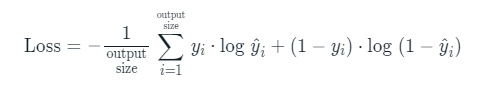

where ŷi is the i-th scalar value in the model output, yi is the corresponding target value and the output size is the number of scalar values in the model output

Such loss computation is done by the discriminator. Usually, a discriminator is used in GAN architectures along side with a generator. However, in this case, we give in input the samples from the two domains and thus the distriminator is used to distinguish the domain from which the input samples come from (basically it becomes a domain classifier). This is possible thanks to domain labels which can made possible to differentiate between the two domains.

In order to connect such domain classifier to the rest of the network a gradient reversal layer is introduced. This gradient reversal layer (GRL) has only the meta-parameter λ associated with it. During the forward propagation, GRL acts as an identity tranform whereas on the backpropagation it takes the gradient, multiples it with -λ and then pass it backwards. Mathematically, the GRL is considered as a "pseudo-function" Rλ(x). During forward propagation Rλ(x) = x. During backpropagation the formula becomes:

dRλ / dx = -λI, where I is the identity matrix.[2]

The λ is handled by the LambdaScheduler class

In [ ]:
from torch.autograd import Function
import numpy as np

class LambdaSheduler(nn.Module):

    #define LambdaScheduler
    def __init__(self, gamma=1.0, max_iter=100, **kwargs):
        super(LambdaSheduler, self).__init__()
        self.gamma = gamma
        self.max_iter = max_iter
        self.curr_iter = 0

    #set a lambda value
    def lamb(self):
        p = self.curr_iter / self.max_iter
        lamb = 2. / (1. + np.exp(-self.gamma * p)) - 1
        return lamb

    #step function
    def step(self):
        self.curr_iter = min(self.curr_iter + 1, self.max_iter)


#Create Discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_dim=256, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        #define the layers
        layers = [
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        ]
        self.layers = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


#create the gradient reversal layer. Since the training follows a backpropagation approach, we define  both forward and backward step functions
class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None


class AdversarialLoss(nn.Module):
    '''
    Acknowledgement: The adversarial loss implementation is inspired by http://transfer.thuml.ai/
    '''
    def __init__(self, gamma=1.0, max_iter=100, **kwargs):
        super(AdversarialLoss, self).__init__()

        #create Discriminator network
        self.domain_classifier = Discriminator()

        #create LambdaScheduler
        self.lambda_scheduler = LambdaSheduler(gamma, max_iter)


    def forward(self, source, target):
        #set lambda value
        lamb = self.lambda_scheduler.lamb()
        self.lambda_scheduler.step()

        #compute adversarial loss results
        source_loss = self.get_adversarial_result(source, True, lamb)
        target_loss = self.get_adversarial_result(target, False, lamb)
        adv_loss = 0.5 * (source_loss + target_loss)

        return adv_loss


    def get_adversarial_result(self, x, source=True, lamb=1.0):
        #apply reverse layer
        x = ReverseLayerF.apply(x, lamb)

        #get domain classifier and device
        domain_pred = self.domain_classifier(x)
        device = domain_pred.device

        #set domain labels
        #if source domain then labels are known, otherwise labels are unknown
        if source:
            domain_label = torch.ones(len(x), 1).long()
        else:
            domain_label = torch.zeros(len(x), 1).long()

        #compute adversarial loss
        loss_fn = nn.BCELoss()
        loss_adv = loss_fn(domain_pred, domain_label.float().to(device))
        return loss_adv


class TransferLoss(nn.Module):

    def __init__(self, **kwargs):
        super(TransferLoss, self).__init__()
        self.loss_func = AdversarialLoss(**kwargs)

    def forward(self, source, target, **kwargs):
        return self.loss_func(source, target, **kwargs)

##Network definition
In the source only part there are only the feature extractor and the label predictor. Now, for the UDA part, along with the feature extractor (green) and the label predictor (blue), it is necessary to add a domain classifier (red) connected to the feature extractor via a gradient reversal layer which multiplies the gradient by a certain negative constant during the training. Otherwise, the training proceeds to minimize the label prediction loss (for source samples) and the domain classificaion loss (for all samples). In this way, gradient reversal ensures that the feature distributions over the two domains are made similar (i.e. as indistinguishable as possible) for the domain classifier , thus resulting in domain-invariant features.

Turning back to the formal statement made in the source only network definition part, now it is possible to perform the mapping of feature vector f to the domain label d by a mapping Gd (domain classifier) with parameters θd.[2]



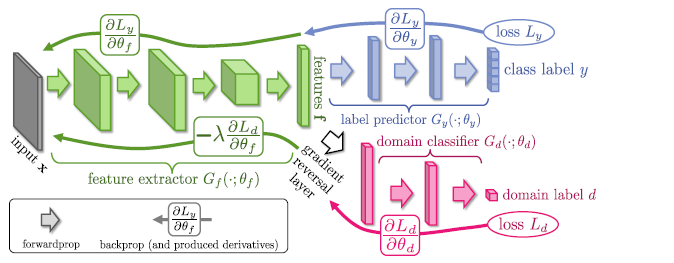

In [ ]:
class TransferNetUDA(nn.Module):
    def __init__(self, num_class, bottleneck_width=256, max_iter=100, **kwargs):
        super(TransferNetUDA, self).__init__()
        self.num_class = num_class

        #get the backbone
        self.model = get_backbone('resnet50')

        #define bottleneck
        bottleneck_list = [
            nn.Linear(self.model.output_num(), bottleneck_width),
            nn.ReLU()
        ]
        self.bottleneck_layer = nn.Sequential(*bottleneck_list)
        feature_dim = bottleneck_width

        #create linear classifier layer
        self.classifier_layer = nn.Linear(feature_dim, num_class)
        transfer_loss_args = {
            "max_iter": max_iter,
            "num_class": num_class
        }

        #get adversarial loss and cost function loss
        self.adv_loss = TransferLoss(**transfer_loss_args)
        self.cost_function = torch.nn.CrossEntropyLoss()

    def forward(self, source, target, source_label):
        #do forward step on source and tagert domain
        source = self.model(source)
        target = self.model(target)

        #do forward step for bottleneck
        source = self.bottleneck_layer(source)
        target = self.bottleneck_layer(target)

        # classification (clf stands for classification)
        source_clf = self.classifier_layer(source)
        clf_loss = self.cost_function(source_clf, source_label)

        # transfer
        kwargs = {}
        transfer_loss = self.adv_loss(source, target, **kwargs)
        return clf_loss, transfer_loss

    def get_parameters(self, initial_lr=1.0):
        #get parameters for SGD optimizer. Note that we multiplie the initial learning rate for the classifier layer, bottleneck layer and domain classifier by 10
        #so it can train faster (usually, with this setup, 15 epoch are enough to see an improvement during training)
        params = [
            {'params': self.model.parameters(), 'lr': initial_lr},
            {'params': self.classifier_layer.parameters(), 'lr': 10 * initial_lr},
        ]

        #set learning rate to bottleneck
        params.append(
            {'params': self.bottleneck_layer.parameters(), 'lr': 10 * initial_lr}
        )

        #set learning rate to domain classifier
        params.append(
            {'params': self.adv_loss.loss_func.domain_classifier.parameters(), 'lr': 10 * initial_lr}
        )
        return params


    #used for testing step
    def predict(self, x):
        features = self.model(x)
        x = self.bottleneck_layer(features)
        clf = self.classifier_layer(x)
        return clf

Creating a model based on TransferNetUDA class made above. In this case, we have to pass the number of classes (always 20 in our case) as parameter.

In [ ]:
transfer_model = TransferNetUDA(20).to(device)  #20 is the number of classes
print(transfer_model)

TransferNetUDA(
  (model): ResNetBackbone(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

##Train and test UDA
###Theoretical ideas


Formally, what is necessary to do is to minimize the label prediction loss on the source domain in order to optimize the parameters of both the feature extractor and the label predictor. At the same we want to make features f domain-invariant, i.e. we want to make the two distributions to be similar. So, in order to obtain domain-invariant features, it is necessary to seek the parameters θf of the feature mapping that maximize the loss of the domain classifier while simultaneously seeking the parameters θd of the domain classifier that minimize the loss of the domain classifier. Moreover, it is necessary to minimize also the loss of the label predictor.

Mathematically [2] , we consider the following function:

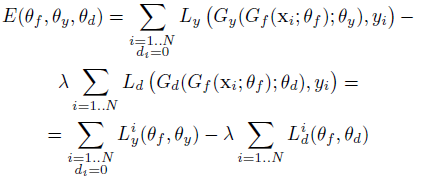

where Ly() is the loss for label prediction while Ld() is the loss for the domain classifier. The parameter λ controls the trade-off between the two objectives that shape the features during the training. Doing this consideration, the parameters that deliver a saddle point of the functional are:




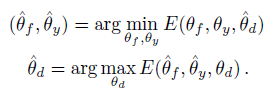

During backpropagation, each parameter is updated via gradient descent update rule as follows (μ is the learning rate)



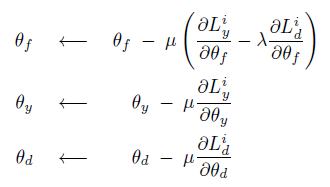

### Train and test functions
The main train and test functions for UDA part of the experiment. Now we also have to train unsupervisedly on the target domain two domains are handled, one of them being the source domain and the other one the target. The test must be done on the target domain. The training algorithm follows the practice of a backpropagation algorithm.

In [ ]:
def train_uda(source_loader, target_train_loader, target_test_loader, model, optimizer, lr_scheduler):

    len_source_loader = len(source_loader)
    len_target_loader = len(target_train_loader)
    n_batch = min(len_source_loader, len_target_loader)

    iter_source, iter_target = iter(source_loader), iter(target_train_loader)

    best_acc = 0

    for e in range(1, n_epoch+1):

        #set model to training mode
        model.train()

        #define AverageMeter variables, necessary to obtain the numbers from tensors
        train_loss_clf = AverageMeter()
        train_loss_transfer = AverageMeter()
        train_loss_total = AverageMeter()
        h_test_acc = AverageMeter()

        if max(len_target_loader, len_source_loader) != 0:
            iter_source, iter_target = iter(source_loader), iter(target_train_loader)

        for _ in range(n_batch):
            # get source and target data
            data_source, label_source = next(iter_source) # .next()
            data_target, _ = next(iter_target) # .next()

            # load data into GPU
            data_source, label_source = data_source.to(
                device), label_source.to(device)
            data_target = data_target.to(device)

            #forward pass and losses application
            clf_loss, transfer_loss = model(data_source, data_target, label_source)
            loss = clf_loss + transfer_loss_weight * transfer_loss

            #optimizer reset
            optimizer.zero_grad()

            #backward pass
            loss.backward()

            #optimizer step: it updates parameters
            optimizer.step()

            #learning rate scheduler step, if available
            lr_scheduler.step()

            #getting data to print
            train_loss_clf.update(clf_loss.item())
            train_loss_transfer.update(transfer_loss.item())
            train_loss_total.update(loss.item())

        # Test
        test_acc, test_loss = test_step_uda(model, target_test_loader)

        h_train_loss_uda.append([train_loss_total.avg])
        h_val_loss_uda.append([test_loss])

        h_test_acc.update(test_acc.item())

        h_val_accuracy_uda.append([h_test_acc.avg])

        #if best accuracy then save the value
        if best_acc < test_acc:
            best_acc = test_acc

        print('Epoch: {:d}'.format(e))
        print('\t Training loss {:.5f}'.format(train_loss_total.avg))
        print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, h_test_acc.avg))
        print('-----------------------------------------------------')

    return best_acc

def test_step_uda(model, target_test_loader):

    #set model to testing mode
    model.eval()
    test_loss = AverageMeter()
    correct = 0

    len_target_dataset = len(target_test_loader.dataset)
    with torch.no_grad():
        for data, target in target_test_loader:

            #load data into GPU
            data, target = data.to(device), target.to(device)

            #forward pass for prediction computation
            s_output = model.predict(data)

            #loss application
            loss = cost_function(s_output, target)

            #get accuracy result
            test_loss.update(loss.item())
            pred = torch.max(s_output, 1)[1]
            correct += torch.sum(pred == target)

    acc = 100. * correct / len_target_dataset
    return acc, test_loss.avg

Preparing variables for training and testing.

In [ ]:
learning_rate = 0.01

params = transfer_model.get_parameters(initial_lr=learning_rate)
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

transfer_loss_weight = 0.1
lr_gamma = 0.0003
lr_decay = 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda x:  learning_rate * (1. + lr_gamma * float(x)) ** (-lr_decay))

Some utilities for train and test functions.

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value
       Code from: https://github.com/pytorch/examples/blob/main/imagenet/main.py#L397
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

Now it is possible to train and test. The value of the best accuracy is saved in acc_uda variable.

After the evaluation, it is possible to repeat the experiment by swapping the source domain with the target domain (i.e. switching the direction of the domain shift)

In [ ]:
h_train_loss_uda = []
h_val_loss_uda = []
h_val_accuracy_uda = []

acc_uda = train_uda(source_train_loader, target_train_loader, target_test_loader, transfer_model, optimizer, scheduler)
acc_uda = acc_uda.item()
print('\t acc_uda: ',acc_uda)

Epoch: 1
	 Training loss 3.02548
	 Test loss 2.89070, Test accuracy 24.00
-----------------------------------------------------
Epoch: 2
	 Training loss 2.85562
	 Test loss 2.76118, Test accuracy 44.50
-----------------------------------------------------
Epoch: 3
	 Training loss 2.63945
	 Test loss 2.58851, Test accuracy 64.50
-----------------------------------------------------
Epoch: 4
	 Training loss 2.37908
	 Test loss 2.38289, Test accuracy 73.00
-----------------------------------------------------
Epoch: 5
	 Training loss 2.07115
	 Test loss 2.14995, Test accuracy 77.00
-----------------------------------------------------
Epoch: 6
	 Training loss 1.73895
	 Test loss 1.91637, Test accuracy 80.25
-----------------------------------------------------
Epoch: 7
	 Training loss 1.40928
	 Test loss 1.66100, Test accuracy 81.00
-----------------------------------------------------
Epoch: 8
	 Training loss 1.13078
	 Test loss 1.46159, Test accuracy 81.50
------------------------------

Once we have both source only accuracy and UDA accuracy, it is possible to compute the value G that represents the gain in training using the domain alignment shift adopted.

In [ ]:
G = acc_uda - acc_so
print("G: ", G)

G:  12.75


#Results and final considerations

In this last section we will discuss about the results of the experiment that have been done for this work and about the considerations that can be possible to do a posteriori of the experiments. In any case, we train on the source domain and test on the target domain, and we train on both directions. Images are transformed (i.e. we apply resizing, random cropping and normalization on them) and are then loaded in this way in order to be able to operate on them.

The approach adopted for this project allows to train on an annotated data in the source domain and on an unannotated data in the target domain. The adaptation is achieved by aligning the distribution of features across the two domains and this alignment is accomplished thorugh backpropagation training.
A convenient aspect of this approach is that even though it is only necessary to add a domain classifier and connect it to the rest of the network via the reversal gradient layer between the domain classifier and the feature extractor, it is possible to achieve state-of-the art results.

In the following table we present the results obtained in both source only part and UDA part for both directions during our experiments, as well as the gain obtained from the difference between the uda accuracy and source only accuracy. Note that these numbers were obtained running the program in a single experiment, so they may be different when running the code again.


|Version| P -> RL | RL -> P |
|:-:|:-:|:-:|
|Source only|74%|92%|
|UDA|84%|94%|
|Gain|10%|2%|




It is also possible to show the results of the accuracies and losses in charts. First we need to import matplotlib libraries that can able us to show the results on charts on then we define the functions that plot the values.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def plot_accuracies(history, uda = False):
    plt.plot(history, '-o')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    if (uda):
      plt.title('Domain adaptation accuracies over epochs')
    else:
      plt.title('Source only accuracies over epochs')

In [ ]:
def plot_losses(history1, history2, uda = False):
    plt.plot(history1, '-go')
    plt.plot(history2, '-ro')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training loss', 'Testing loss'])

    if (uda):
      plt.title('Domain adaptation losses over epochs')
    else:
      plt.title('Source only losses over epochs')

###Product image --> Real life

Our first experiment was considering the real life dataset as the target domain. It was immediatly possible to guess that training in this direction would be more challenging. Intuitively, in this case the model trains supervisedly on images of objects that are in a white background (product images) and thus the models do its evaluation on a dataset where the images are actually on a real life background, so this means that it is more difficult for the model to understand what object it is if that object is located on a colorated background. After doing the real training (source only) on this direction, we had confimation about such thought.

If we choose the real life domain as the target domain, we observe that the model hardly recongnizes the objects at testing time when training on the source domain and test on the target domain (without the UDA strategy). Instead, if the UDA strategy is applied, the model gets a better accuracy in classifing the images. In fact, the improvement provided by this strategy is quite significant in respect to the source only accuracy score (about 10% in improvement) but training in this direction is still a difficult undertaking for the model.




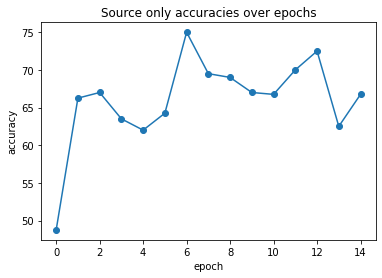

In [ ]:
plot_accuracies(h_val_accuracy_so)

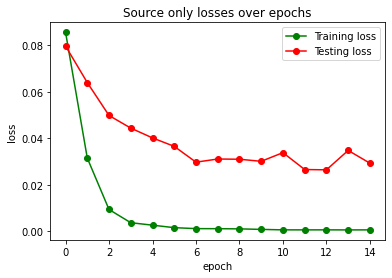

In [ ]:
plot_losses(h_train_loss_so, h_val_loss_so)

UDA charts

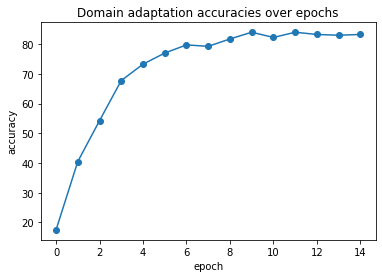

In [ ]:
plot_accuracies(h_val_accuracy_uda, uda = True)

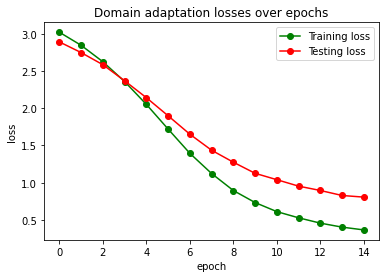

In [ ]:
plot_losses(h_train_loss_uda, h_val_loss_uda, uda = True)

###Real life --> Product Image

After testing on the "product image--> real life" direction, it was the turn to do the experiments in the opposite direction. This time product image is considered as the target domain and we immediately observed that the scores obtained from training an testing functions were much higher than in the previous direction.

What we observed is that when the product images domain is chosen as the target domain the accuracy gets immediatly higher accuracy values (it takes just few epochs to reach 90% accuracy). Considering the intuition made in the previous direction, in this case the model is training now on samples representing objects in real life images which means that evaluating on images of objects in white background results much easier than in the other direction. This because the target dataset has images representing only the object while the model is trained on images with a real life background, which can be a noise element Randomly cropping images also helps in data augmentation, so the accuracy value results being high.

Adding UDA approach, however, does not result in any significant improvement in the classification accuracy (only about 2% in improvement, even less in certain instances). But this little improvement is also due to the fact that in both cases the accuracy score is very high, probably even too high. Since accuracy scores reach in both cases at least 92% accuracy, it is possible that the model is overfitting in this case.


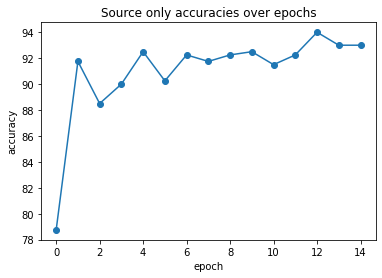

In [ ]:
plot_accuracies(h_val_accuracy_so)

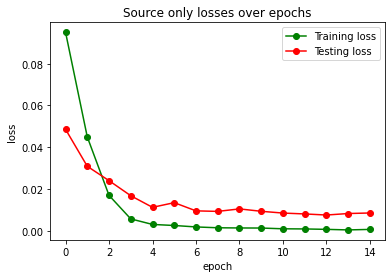

In [ ]:
plot_losses(h_train_loss_so, h_val_loss_so)

UDA charts

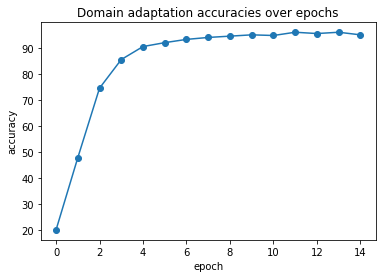

In [ ]:
plot_accuracies(h_val_accuracy_uda, uda = True)

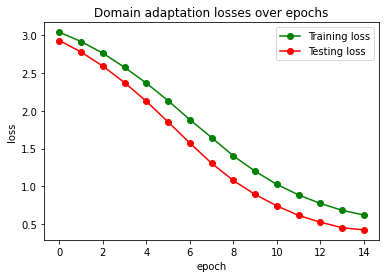

In [ ]:
plot_losses(h_train_loss_uda, h_val_loss_uda, uda = True)

#References
[1] Tobias Ringwald and Rainer Stiefelhagen. Adaptiope: A modern benchmark for unsupervised domain
adaptation. In 2021 IEEE Winter Conference on Applications of Computer Vision (WACV)

[2] Yaroslav Ganin and Victor Lempitsky. Unsupervised Domain Adaptation by Backpropagation

[3] https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/binary-crossentropy